# Personalized Cancer Diagnosis

## Description
<p>A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.</p>
<p>Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers).  As not all mutations lead to cancer.</p>
<p>Due to a mutation in a gene, there is some genetic variation developed in a gene. But the question comes, from which particular mutation this genetic variation happened in a gene. Currently this interpretation of genetic mutations is being done manually which is a very time-consuming task. Based on a gene and a variation in it, a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.</p>


## Business Problem
<p>The workflow is as follows:</p>
<p>1. A molecular pathologist selects a list of genetic variations of interest that he/she want to analyze.</p>
<p>2. The molecular pathologist searches for evidence in the medical literature that somehow are relevant to the genetic variations of interest.</p>
<p>3. Finally, this molecular pathologist spends a huge amount of time analyzing the evidence related to each of the variations to classify them into any one of the 9 different classes.</p>
<p>Our goal here is to replace step 3 by a machine learning model. The molecular pathologist will still have to decide which variations are of interest, and also collect the relevant evidence for them. But the last step, which is also the most time consuming, will be fully automated by a machine learning model.</p>

## Problem Statement
<p>Classify the given genetic variations/mutations based on evidence from text-based clinical literature. In this problem, we need to find the mutation-type given the gene, variation and some text data from published research.</p>

## Source of Data
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data</p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>

## Real-world/Business objectives and constraints.
* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

## Machine Learning Problem Formulation
### Data Overview
<p>- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data</p>
<p>- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. Both these data files are have a common column called ID.</p>
<p>Data file's information:</p>
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>

## Mapping the real-world problem to an ML problem

### Type of Machine Learning Problem

<p>There are nine different classes a genetic mutation can be classified into => Multi class classification problem</p>

### Performance Metric

<p>Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation</p>

<h4 style = "font-size:17px">Metric(s):</h4>

<ul> 
    <li>
        Multi class log-loss
    </li>
    <li>
        Confusion matrix 
    </li>
</ul>

## File Descriptions
<p><b>TrainingData</b> - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)</p>
<p><b>TrainingText</b> - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)</p>

## Train, CV and Test Datasets
<p> Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively</p>

<h1>Exploratory Data Analysis</h1>

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import math
import re
warnings.simplefilter('ignore')
from collections import Counter, defaultdict
from scipy.sparse import hstack
from scipy.sparse import vstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss

In [86]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<h1>Reading Data</h1>

In [87]:
data = pd.read_csv("Data/TrainingData")

In [93]:
data.head(10)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [6]:
data.shape

(3321, 4)

In [7]:
data_text = pd.read_csv("Data/TrainingText", sep = "\|\|", names = ["ID", "Text"])

In [8]:
data_text = data_text.drop(0, axis = 0)

In [9]:
data_text = data_text.reset_index(drop = True)

In [10]:
data_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [11]:
data_text.shape

(3321, 2)

In [12]:
data_text = data_text.drop(["ID"], axis = 1)

In [13]:
Final_Data = pd.concat([data, data_text], axis = 1)

In [14]:
Final_Data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [15]:
Final_Data_Label = Final_Data["Class"]

In [16]:
Final_Data = Final_Data.drop(["Class"], axis = 1)

In [17]:
Final_Data.head()

,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


In [18]:
Final_Data = pd.concat([Final_Data, Final_Data_Label], axis = 1)

In [19]:
Final_Data.head()

,ID,Gene,Variation,Text,Class
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...,1
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...,2
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...,2
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...,3
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...,4


In [20]:
#checking for rows having text column as nan
for index, textinfo in Final_Data.iterrows():
    if type(textinfo["Text"]) is not str:
        print(index)

1109
1277
1407
1639
2755


In [21]:
#removing rows with text data as nan
for index, textinfo in Final_Data.iterrows():
    if type(textinfo["Text"]) is not str:
        Final_Data.drop(index, axis = 0, inplace = True)

In [22]:
Final_Data.shape

(3316, 5)

In [23]:
def pre_processing(clinicalText, indexNumber, columnName):
    if type(clinicalText) is not int:
        textString = ""
        #removing special characters
        clinicalText1 = re.sub('[^a-zA-Z0-9\n]', ' ', clinicalText)
        #remove any spaces
        clinicalText2 = re.sub('\s+', ' ', clinicalText1)
        #converting text to lowercase
        textString += clinicalText2.lower()
        Final_Data[columnName][indexNumber] = textString

In [29]:
Final_Data.head()

,ID,Gene,Variation,Text,Class
0,0,FAM58A,Truncating_Mutations,Cyclin-dependent kinases (CDKs) regulate a var...,1
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...,2
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...,2
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...,3
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...,4


In [30]:
Final_Data_Labels = Final_Data["Class"]

In [31]:
Final_Data.shape, Final_Data_Labels.shape

((3316, 5), (3316,))

<h1>Train, cross-validation and test split</h1>
<p> Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively.</p>

In [32]:
#replacing any space with underscore
Final_Data["Gene"] = Final_Data["Gene"].str.replace("\s+", "_")
Final_Data["Variation"] = Final_Data["Variation"].str.replace("\s+", "_")

In [33]:
Final_Data.head()

,ID,Gene,Variation,Text,Class
0,0,FAM58A,Truncating_Mutations,Cyclin-dependent kinases (CDKs) regulate a var...,1
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...,2
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...,2
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...,3
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...,4


In [34]:
X_Train, TestData, Y_Train, TestLabels = train_test_split(Final_Data, Final_Data_Labels, stratify=Final_Data_Labels, test_size=0.2)
TrainData, CV_Data, TrainDataLabels, CV_Data_Labels = train_test_split(X_Train, Y_Train, stratify=Y_Train, test_size=0.2)

# This stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the 
# proportion of values provided to parameter stratify.
# For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, 
# stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

In [35]:
X_Train.shape, TestData.shape, Y_Train.shape, TestLabels.shape

((2652, 5), (664, 5), (2652,), (664,))

In [36]:
print('Number of data points in train data:', TrainData.shape[0])
print('Number of data points in test data:', TestData.shape[0])
print('Number of data points in cross validation data:', CV_Data.shape[0])

Number of data points in train data: 2121
Number of data points in test data: 664
Number of data points in cross validation data: 531


<h1>Distribution of Class labels in Train, CV and Test data</h1>

In [37]:
TrainData_distribution = TrainData["Class"].value_counts().sort_index()
CVData_distribution = CV_Data["Class"].value_counts().sort_index()
TestData_distribution = TestData["Class"].value_counts().sort_index()

In [38]:
TrainData_distribution_sorted = sorted(TrainData_distribution.items(), key = lambda d: d[1], reverse = True)
CVData_distribution_sorted = sorted(CVData_distribution.items(), key = lambda d: d[1], reverse = True)
TestData_distribution_sorted = sorted(TestData_distribution.items(), key = lambda d: d[1], reverse = True)

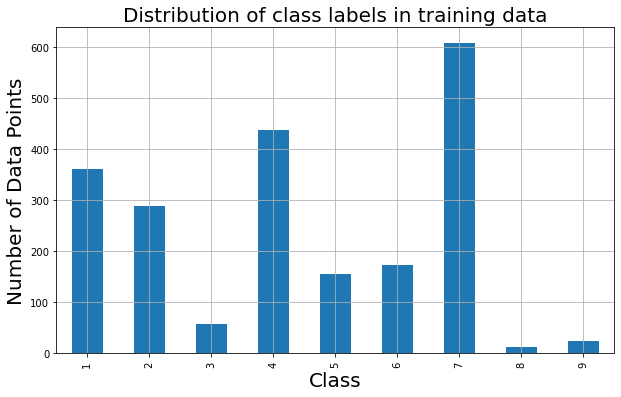

Number of training data points in class 7 = 609(28.7129%)
Number of training data points in class 4 = 439(20.6978%)
Number of training data points in class 1 = 362(17.0674%)
Number of training data points in class 2 = 289(13.6256%)
Number of training data points in class 6 = 174(8.2037%)
Number of training data points in class 5 = 155(7.3079%)
Number of training data points in class 3 = 57(2.6874%)
Number of training data points in class 9 = 24(1.1315%)
Number of training data points in class 8 = 12(0.5658%)
--------------------------------------------------------------------------------


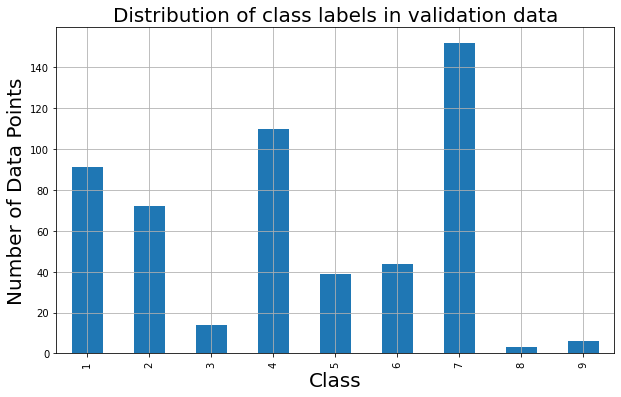

Number of CV data points in class 7 = 152(28.6252%)
Number of CV data points in class 4 = 110(20.7156%)
Number of CV data points in class 1 = 91(17.1375%)
Number of CV data points in class 2 = 72(13.5593%)
Number of CV data points in class 6 = 44(8.2863%)
Number of CV data points in class 5 = 39(7.3446%)
Number of CV data points in class 3 = 14(2.6365%)
Number of CV data points in class 9 = 6(1.1299%)
Number of CV data points in class 8 = 3(0.565%)
--------------------------------------------------------------------------------


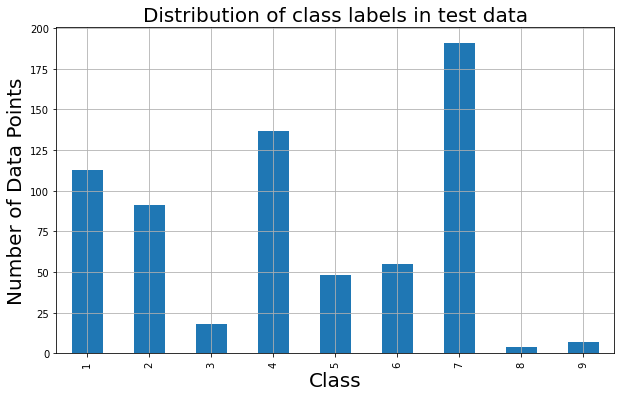

Number of test data points in class 7 = 191(28.7651%)
Number of test data points in class 4 = 137(20.6325%)
Number of test data points in class 1 = 113(17.0181%)
Number of test data points in class 2 = 91(13.7048%)
Number of test data points in class 6 = 55(8.2831%)
Number of test data points in class 5 = 48(7.2289%)
Number of test data points in class 3 = 18(2.7108%)
Number of test data points in class 9 = 7(1.0542%)
Number of test data points in class 8 = 4(0.6024%)


In [39]:
plt.figure(figsize = (10, 6))
TrainData_distribution.plot(kind = "bar")
plt.grid()
plt.title("Distribution of class labels in training data", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Data Points", fontsize = 20)
plt.show()

for i in TrainData_distribution_sorted:
    print("Number of training data points in class "+str(i[0])+" = "+str(i[1])+ "("+str(np.round(((i[1]/TrainData.shape[0])*100), 4))+"%)")

print("-"*80)

plt.figure(figsize = (10, 6))
CVData_distribution.plot(kind = "bar")
plt.grid()
plt.title("Distribution of class labels in validation data", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Data Points", fontsize = 20)
plt.show()

for i in CVData_distribution_sorted:
    print("Number of CV data points in class "+str(i[0])+" = "+str(i[1])+ "("+str(np.round(((i[1]/CV_Data.shape[0])*100), 4))+"%)")

print("-"*80)

plt.figure(figsize = (10, 6))
TestData_distribution.plot(kind = "bar")
plt.grid()
plt.title("Distribution of class labels in test data", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Data Points", fontsize = 20)
plt.show()

for i in TestData_distribution_sorted:
    print("Number of test data points in class "+str(i[0])+" = "+str(i[1])+ "("+str(np.round(((i[1]/TestData.shape[0])*100), 4))+"%)")


In [40]:
def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    labels = [i for i in range(1, 10)]
    
    plt.figure(figsize=(20,7))
    sns.heatmap(confusionMatx, cmap = "Reds", annot = True, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.show()
    
    print("-"*125)
    
    plt.figure(figsize=(20,7))
    sns.heatmap(precision, cmap = "Reds", annot = True, fmt = ".4f", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.show()
    
    print("-"*125)
    
    plt.figure(figsize=(20,7))
    sns.heatmap(recall, cmap = "Reds", annot = True, fmt = ".3f", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.show()

In [41]:
def response_coded_featureDict(alpha, feature, df):
    
    value_count = TrainData[feature].value_counts()
    rc_values = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1, 10):
            cls_cnt = TrainData.loc[(TrainData["Class"]==k) & (TrainData[feature]==i)]
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+(90*alpha))
# here, adding 10*alpha in numerator and 90*alpha in denominator is nothing but laplace smoothing which we did in Naive Bayes 
            vec.append((cls_cnt.shape[0] + 10*alpha)/denominator + (90*alpha))    
        rc_values[i] = vec
    return rc_values


def response_coded_values(alpha, feature, df):
    get_rc_values = response_coded_featureDict(alpha, feature, df)
    get_value_count = TrainData[feature].value_counts()
    get_feat_values = []
    for index, row in df.iterrows():
        if row[feature] in dict(get_value_count).keys():
            get_feat_values.append(get_rc_values[row[feature]])
        else:
            get_feat_values.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return get_feat_values

When we calculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + alpha) / (denominator + (9*alpha)) </li>

<h1>Univariate Analysis on Gene Feature</h1>

<p> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p><b>Ans.</b> Gene is a categorical variable </p>
<p> <b>Q2.</b> How many categories are there and how they are distributed?</p>

In [42]:
unique_genes = TrainData["Gene"].value_counts()
print("Number of Unique genes = "+str(unique_genes.shape[0]))
print(unique_genes.head(10))

Number of Unique genes = 229
BRCA1     174
TP53      107
EGFR       91
PTEN       81
BRCA2      70
KIT        65
BRAF       57
ERBB2      42
ALK        42
PIK3CA     35
Name: Gene, dtype: int64


In [43]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows:")

Ans: There are 229 different categories of genes in the train data, and they are distibuted as follows:


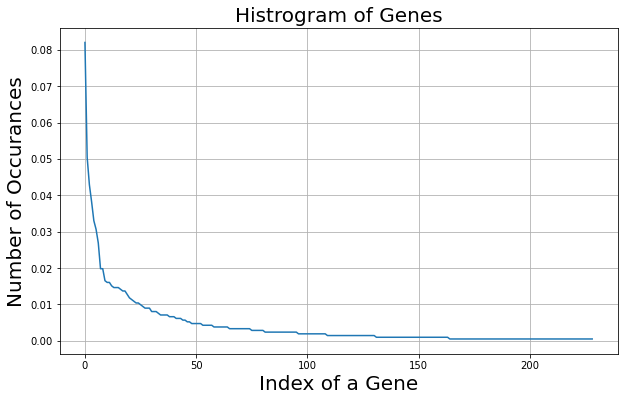

In [44]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.figure(figsize = (10, 6))
plt.plot(h)
plt.title("Histrogram of Genes", fontsize = 20)
plt.xlabel('Index of a Gene', fontsize = 20)
plt.ylabel('Number of Occurances', fontsize = 20)
plt.grid()
plt.show()

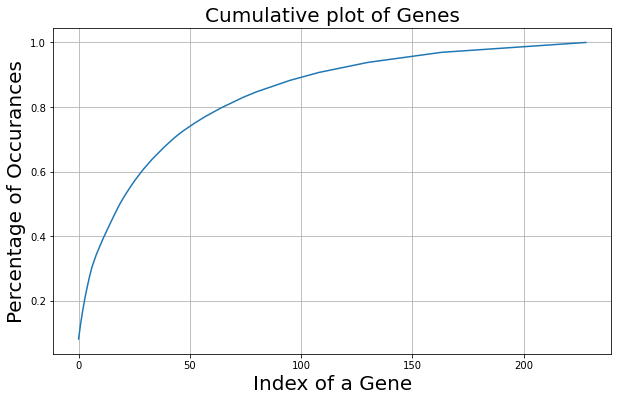

In [45]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(h))
plt.title("Cumulative plot of Genes", fontsize = 20)
plt.xlabel('Index of a Gene', fontsize = 20)
plt.ylabel('Percentage of Occurances', fontsize = 20)
plt.grid()
plt.show()

<p> <b>Q3.</b> How to featurize this Gene feature ?</p>
<ol><li>Response Coding</li><li>One-hot Coding</li></ol>

In [46]:
geneVectorizer = CountVectorizer()
train_gene_feature_onehotCoding = geneVectorizer.fit_transform(TrainData['Gene'])
test_gene_feature_onehotCoding = geneVectorizer.transform(TestData['Gene'])
cv_gene_feature_onehotCoding = geneVectorizer.transform(CV_Data['Gene'])

In [47]:
print("Size of one-hot encoded features in train data = "+str(train_gene_feature_onehotCoding.shape))
print("Size of one-hot encoded features in test data = "+str(test_gene_feature_onehotCoding.shape))
print("Size of one-hot encoded features in CV data = "+str(cv_gene_feature_onehotCoding.shape))

Size of one-hot encoded features in train data = (2121, 228)
Size of one-hot encoded features in test data = (664, 228)
Size of one-hot encoded features in CV data = (531, 228)


<h3>Q4. How good is this gene feature in predicting y_i?</h3>
<p>There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.</p>

For alpha value of 1e-05 CV log loss = 1.244407017996614
For alpha value of 0.0001 CV log loss = 1.2236147935553234
For alpha value of 0.001 CV log loss = 1.2634287653226461
For alpha value of 0.01 CV log loss = 1.3694916361428768
For alpha value of 0.1 CV log loss = 1.446977296937574
For alpha value of 1 CV log loss = 1.4943477915070729


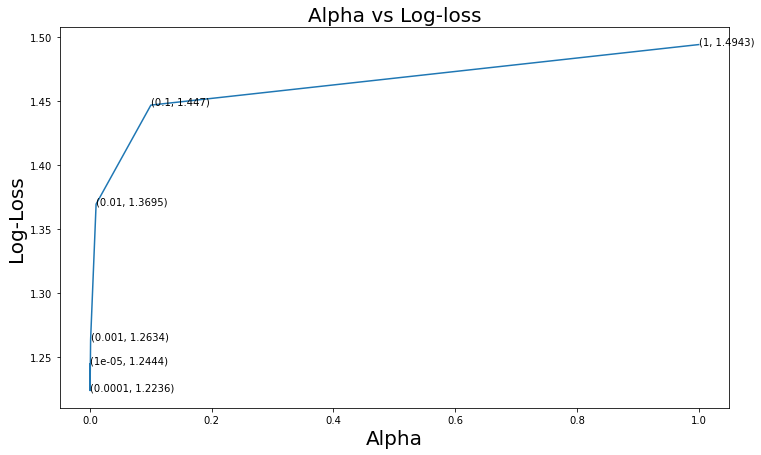

In [48]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, TrainDataLabels)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    #this is a cross-validation
    calib_clf.fit(train_gene_feature_onehotCoding, TrainDataLabels)
    predicted_y = calib_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_loss.append(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [49]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, TrainDataLabels)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(train_gene_feature_onehotCoding, TrainDataLabels)

predict_train = calib_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(TrainDataLabels, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(CV_Data_Labels, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(TestLabels, predict_test, labels=clf.classes_))

For values of best alpha =  0.0001 the train log loss =: 0.9860858183168849
For values of best alpha =  0.0001 the CV log loss =: 1.2236147935553234
For values of best alpha =  0.0001 the test log loss =: 1.1604878365129419


<h3>Q5. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</h3>
<p> <b>Ans:</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.</p>

In [50]:
print("Ques: How many common gene features are there in train, cv and test data?")
gene_common_in_test = TestData[TestData["Gene"].isin(TrainData["Gene"])].shape[0]
gene_common_in_cv = CV_Data[CV_Data["Gene"].isin(TrainData["Gene"])].shape[0]
print("Ans:")
print("Percentage of common gene features in test and train data = "+str(np.round((gene_common_in_test/TestData.shape[0])*100, 2))+"%")
#it prints: Out of total features in test data, how many features are also present in train data
print("Percentage of common gene features in CV and train data = "+str(np.round((gene_common_in_cv/CV_Data.shape[0])*100, 2))+"%")
#it prints: Out of total features in cv data, how many features are also present in train data

Ques: How many common gene features are there in train, cv and test data?
Ans:
Percentage of common gene features in test and train data = 96.23%
Percentage of common gene features in CV and train data = 96.61%


<h1>Univariate Analysis on Variation Feature</h1>

<p>Q1. Variation, What type of feature is it?</p>
<p><b>Ans.</b> Variation is a categorical variable</p>
<p>Q2. How many categories are there?</p>

In [51]:
unique_variation = TrainData["Variation"].value_counts()
print("Number of Unique variations = "+str(unique_variation.shape[0]))
print(unique_variation.head(10))

Number of Unique variations = 1918
Truncating_Mutations    62
Deletion                47
Amplification           45
Fusions                 25
Overexpression           4
E17K                     3
T58I                     3
G12A                     2
Q61K                     2
F384L                    2
Name: Variation, dtype: int64


In [52]:
print("Ans: There are", unique_variation.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows:")

Ans: There are 1918 different categories of variations in the train data, and they are distibuted as follows:


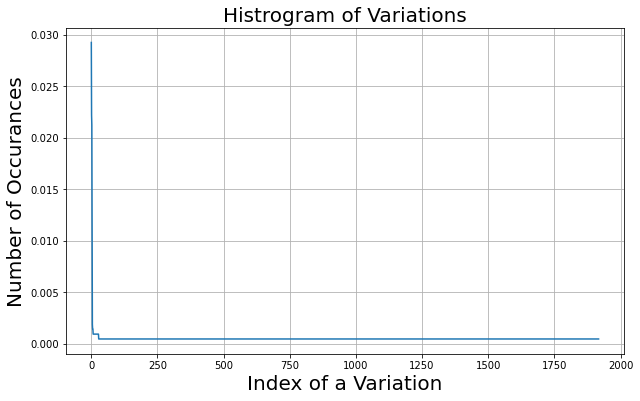

In [53]:
s = sum(unique_variation.values)
h = unique_variation.values/s
plt.figure(figsize = (10, 6))
plt.plot(h)
plt.title("Histrogram of Variations", fontsize = 20)
plt.xlabel('Index of a Variation', fontsize = 20)
plt.ylabel('Number of Occurances', fontsize = 20)
plt.grid()
plt.show()

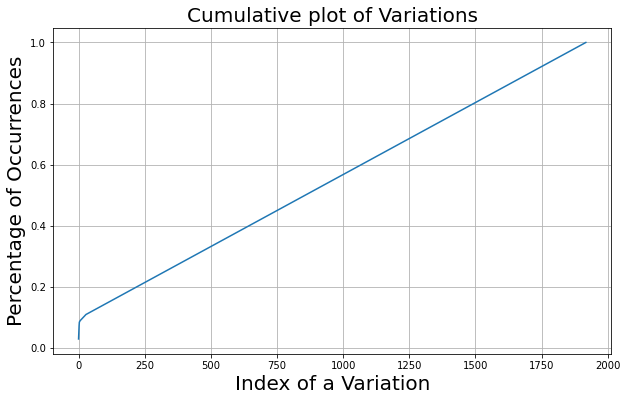

In [54]:
s = sum(unique_variation.values)
h = unique_variation.values/s
c = np.cumsum(h)
plt.figure(figsize = (10, 6))
plt.plot(c)
plt.title("Cumulative plot of Variations", fontsize = 20)
plt.xlabel('Index of a Variation', fontsize = 20)
plt.ylabel('Percentage of Occurrences', fontsize = 20)
plt.grid()
plt.show()

<p> <b>Q3.</b> How to featurize this Variation feature ?</p>
<ol><li>One-hot Coding</li></ol>

In [55]:
variationVectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variationVectorizer.fit_transform(TrainData['Variation'])
test_variation_feature_onehotCoding = variationVectorizer.transform(TestData['Variation'])
cv_variation_feature_onehotCoding = variationVectorizer.transform(CV_Data['Variation'])

In [56]:
print("Size of one-hot encoded features in train data = "+str(train_variation_feature_onehotCoding.shape))
print("Size of one-hot encoded features in test data = "+str(test_variation_feature_onehotCoding.shape))
print("Size of one-hot encoded features in CV data = "+str(cv_variation_feature_onehotCoding.shape))

Size of one-hot encoded features in train data = (2121, 1948)
Size of one-hot encoded features in test data = (664, 1948)
Size of one-hot encoded features in CV data = (531, 1948)


<h3>Q4. How good is this Variation feature in predicting y_i?</h3>
<p>There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Variation feature (one hot encoded) to predict y_i.</p>

For alpha value of 1e-05 CV log loss = 1.7148231310754665
For alpha value of 0.0001 CV log loss = 1.7054534487653776
For alpha value of 0.001 CV log loss = 1.7126893373874694
For alpha value of 0.01 CV log loss = 1.7232276952213184
For alpha value of 0.1 CV log loss = 1.7245126527932988
For alpha value of 1 CV log loss = 1.7250032680622196


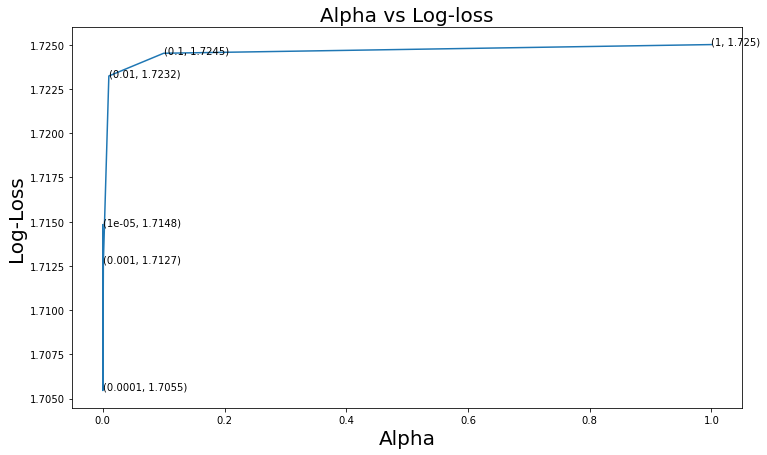

In [57]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, TrainDataLabels)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(train_variation_feature_onehotCoding, TrainDataLabels)
    predicted_y = calib_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_loss.append(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [58]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, TrainDataLabels)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(train_variation_feature_onehotCoding, TrainDataLabels)

predict_train = calib_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(TrainDataLabels, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(CV_Data_Labels, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(TestLabels, predict_test, labels=clf.classes_))

For values of best alpha =  0.0001 the train log loss =: 0.7134851851397425
For values of best alpha =  0.0001 the CV log loss =: 1.7054534487653776
For values of best alpha =  0.0001 the test log loss =: 1.72431338180913


<h3>Q5. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</h3>
<p> <b>Ans:</b> Not sure, let's check it out.</p>

In [59]:
print("Ques: How many common variation features are there in train, cv and test data?")
variation_common_in_test = TestData[TestData["Variation"].isin(TrainData["Variation"])].shape[0]
variation_common_in_cv = CV_Data[CV_Data["Variation"].isin(TrainData["Variation"])].shape[0]
print("Ans:")
print("Percentage of common Variation features in test and train data = "+str(np.round((variation_common_in_test/TestData.shape[0])*100, 2))+"%")
#it prints: Out of total features in test data, how many features are also present in train data
print("Percentage of common Variation features in CV and train data = "+str(np.round((variation_common_in_cv/CV_Data.shape[0])*100, 2))+"%")
#it prints: Out of total features in cv data, how many features are also present in train data

Ques: How many common variation features are there in train, cv and test data?
Ans:
Percentage of common Variation features in test and train data = 9.34%
Percentage of common Variation features in CV and train data = 10.17%


<h1>Univariate Analysis on Text Feature</h1>

### How many unique words are present in train data?

In [60]:
dictt = defaultdict(int)
for index, row in TrainData.iterrows():
    for word in row['Text'].split():
        dictt[word] += 1
print("Number of unique words in train data = "+str(len(dictt.keys())))

Number of unique words in train data = 390670


<p>How to featurize text field?</p>
<ol>
    <li>TFIDF</li>
</ol>

<p><b>TFIDF</b></p>

In [61]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words = "english", min_df = 3, max_features = 100000)

train_text_feature_tfidf = tfidf_vectorizer.fit_transform(TrainData['Text'])
train_text_feature_tfidf = StandardScaler(with_mean = False).fit_transform(train_text_feature_tfidf)

test_text_feature_tfidf = tfidf_vectorizer.transform(TestData['Text'])
test_text_feature_tfidf = StandardScaler(with_mean = False).fit_transform(test_text_feature_tfidf)

cv_text_feature_tfidf = tfidf_vectorizer.transform(CV_Data['Text'])
cv_text_feature_tfidf = StandardScaler(with_mean = False).fit_transform(cv_text_feature_tfidf)

In [62]:
print("Size of TFIDF coded text feature of Train Data = "+str(train_text_feature_tfidf.shape))
print("Size of TFIDF coded text feature of Test Data = "+str(test_text_feature_tfidf.shape))
print("Size of TFIDF coded text feature of CV Data = "+str(cv_text_feature_tfidf.shape))

Size of TFIDF coded text feature of Train Data = (2121, 100000)
Size of TFIDF coded text feature of Test Data = (664, 100000)
Size of TFIDF coded text feature of CV Data = (531, 100000)


### How are word frequencies distributed?

In [63]:
count_vec = CountVectorizer(min_df = 3)
TrainWordOccurrences = count_vec.fit_transform(TrainData['Text'])
# getting all the feature names (words)
TrainFeatures= count_vec.get_feature_names()

# TrainWordOccurrences.sum(axis=0).A1 will sum every column and returns (1*number of features) vector
wordOccurrenceDictionary = dict(zip(TrainFeatures,TrainWordOccurrences.sum(axis=0).A1))

In [64]:
sortedWordOccurrenceDict = dict(sorted(wordOccurrenceDictionary.items(), key=lambda x: x[1] , reverse=True))

In [65]:
sortedWordOccurrenceDictList = np.array(list(sortedWordOccurrenceDict.values()))

In [66]:
NoOfWord_Occurrence = Counter(sortedWordOccurrenceDictList) 
#counter simply takes a list then it prints a dictionary. In that dictionary, keys are the number of elements and its values 
#are the number of times that element is occurring in that list.

In [67]:
print(NoOfWord_Occurrence)
#this will print a dictionary where keys are number of word and its values are the number of times that word in appearing in
#train data. For eg, in below dictionary 3 words are occurring 5316 times, 4 words are occurring 3385 times and so on.

Counter({3: 6266, 4: 3314, 6: 3165, 5: 3018, 7: 1914, 9: 1824, 8: 1793, 11: 1413, 10: 1405, 12: 1385, 14: 1142, 15: 870, 18: 830, 13: 800, 16: 666, 20: 645, 21: 594, 19: 551, 24: 503, 17: 503, 22: 444, 25: 424, 23: 415, 38: 368, 27: 356, 29: 347, 44: 346, 30: 345, 33: 328, 26: 321, 28: 320, 32: 289, 36: 280, 40: 254, 37: 249, 31: 246, 34: 235, 35: 234, 45: 217, 42: 212, 48: 192, 39: 176, 50: 172, 41: 171, 46: 163, 55: 156, 43: 150, 54: 147, 47: 147, 60: 144, 61: 140, 49: 138, 52: 136, 70: 131, 59: 131, 56: 129, 51: 129, 88: 123, 63: 123, 53: 121, 57: 120, 65: 119, 58: 115, 72: 111, 64: 110, 68: 106, 62: 102, 66: 101, 84: 97, 71: 93, 73: 85, 67: 82, 76: 80, 74: 80, 77: 76, 78: 74, 75: 74, 79: 73, 80: 72, 83: 71, 89: 70, 69: 69, 96: 67, 82: 67, 109: 66, 93: 66, 90: 66, 91: 65, 86: 64, 99: 61, 87: 61, 108: 60, 105: 60, 85: 60, 97: 59, 92: 56, 132: 55, 101: 55, 95: 54, 81: 54, 110: 52, 94: 51, 103: 50, 100: 50, 130: 49, 115: 49, 111: 49, 114: 48, 98: 48, 113: 47, 119: 46, 102: 46, 135: 45,

### Is the text feature useful in predicitng y_i?

For alpha value of 1e-05 CV log loss = 1.8319637044429844
For alpha value of 0.0001 CV log loss = 1.556403046457776
For alpha value of 0.001 CV log loss = 1.3942256088913025
For alpha value of 0.01 CV log loss = 1.3885294044609282
For alpha value of 0.1 CV log loss = 1.281699630378601
For alpha value of 1 CV log loss = 1.1144971327761948
For alpha value of 10 CV log loss = 1.119463882190078
For alpha value of 15 CV log loss = 1.1291693252319857
For alpha value of 20 CV log loss = 1.1396258319267831
For alpha value of 40 CV log loss = 1.1743931054055414


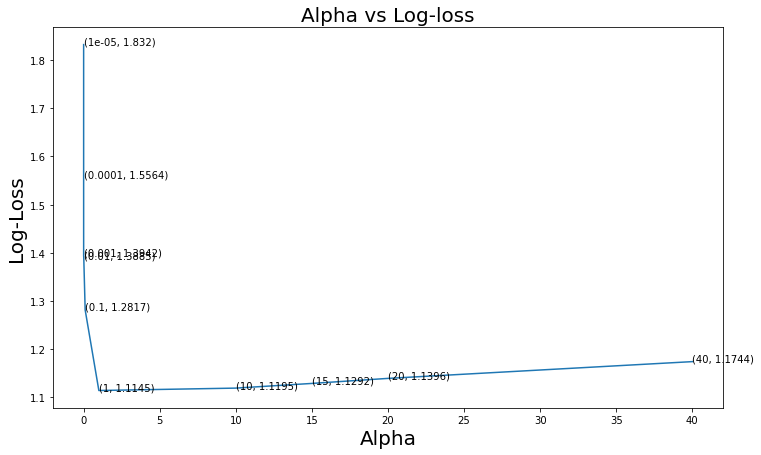

In [80]:
alpha = [10 ** x for x in range(-5, 2)]
alpha.append(15)
alpha.append(20)
alpha.append(40)

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_tfidf, TrainDataLabels)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(train_text_feature_tfidf, TrainDataLabels)
    predicted_y = calib_clf.predict_proba(cv_text_feature_tfidf)
    cv_log_loss.append(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [81]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_tfidf, TrainDataLabels)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(train_text_feature_tfidf, TrainDataLabels)

predict_train = calib_clf.predict_proba(train_text_feature_tfidf)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(TrainDataLabels, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(cv_text_feature_tfidf)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(CV_Data_Labels, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(test_text_feature_tfidf)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(TestLabels, predict_test, labels=clf.classes_))

For values of best alpha =  1 the train log loss =: 0.5642905851156057
For values of best alpha =  1 the CV log loss =: 1.1144971327761948
For values of best alpha =  1 the test log loss =: 1.0627781663251301


### Is the text feature stable across train, test and CV datasets?

In [82]:
def checkingCommonFeatures(df):
    count_vect = CountVectorizer(min_df = 3)
    BoWMatrx = count_vect.fit_transform(df["Text"])
    BoWMatrxFeatures = count_vect.get_feature_names()
    BoWMatrxFeaturesUnique = len(set(BoWMatrxFeatures))
    commonFeatures = len(set(TrainFeatures) & set(BoWMatrxFeatures))
    return BoWMatrxFeaturesUnique, commonFeatures

In [83]:
count_vect = CountVectorizer(min_df = 3)
BoWMatrx = count_vect.fit_transform(TestData["Text"])
BoWMatrxFeatures = count_vect.get_feature_names()

In [84]:
len1, len2 = checkingCommonFeatures(TestData)
print("Percentage of common features in train and test data = "+str(np.round((len2/len1)*100, 4))+"%")
#it prints: Out of total features in test data, how many features are also present in train data
len3, len4 = checkingCommonFeatures(CV_Data)
print("Percentage of common features in train and CV data = "+str(np.round((len4/len3)*100, 4))+"%")
#it prints: Out of total features in CV data, how many features are also present in train data

Percentage of common features in train and test data = 98.2432%
Percentage of common features in train and CV data = 97.1968%


<h1>Machine Learning Model</h1>

In [68]:
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def getImportantFeatures(indices, gene, variation, text, noOfFeatures):
    gene_vect = CountVectorizer()
    var_vect = CountVectorizer()
    text_vect = TfidfVectorizer(ngram_range = (1,2), stop_words = "english", min_df = 3, max_features = 100000)
    
    geneVect = gene_vect.fit(TrainData['Gene'])
    varVect  = var_vect.fit(TrainData['Variation'])
    textVect = text_vect.fit(TrainData['Text'])
    
    gene_features = gene_vect.get_feature_names()
    variation_features = varVect.get_feature_names()
    text_features = text_vect.get_feature_names()
    
    gene_feat_len = len(gene_features)
    var_feat_len = len(variation_features)
    
    First = [x1 for x1 in range(0, 491, 10)]
    del First[1]
    Second = [x2 for x2 in range(1, 492, 10)]
    del Second[1]
    Third = [x3 for x3 in range(2, 493, 10)]
    del Third[1]
    
    word_present = 0
    for i, v in enumerate(indices):
        if v < gene_feat_len:
            word = gene_features[v]
            
            if word == gene:
                word_present += 1
                
                if i in First:
                    print("{}st Gene feature [{}] is present in query point".format(i+1, word))
                
                elif i in Second:
                    print("{}nd Gene feature [{}] is present in query point".format(i+1, word))
                
                elif i in Third:
                    print("{}rd Gene feature [{}] is present in query point".format(i+1, word))
                    
                else:
                    print("{}th Gen feature [{}] is present in query point".format(i+1, word))
                    
        elif v < gene_feat_len + var_feat_len:
            word = variation_features[v - gene_feat_len]
            
            if word == variation:
                word_present += 1
                if i in First:
                    print("{}st Variation feature [{}] is present in query point".format(i+1, word))
                
                elif i in Second:
                    print("{}nd Variation feature [{}] is present in query point".format(i+1, word))
                
                elif i in Third:
                    print("{}rd Variation feature [{}] is present in query point".format(i+1, word))
                    
                else:
                    print("{}th Variation feature [{}] is present in query point".format(i+1, word))
        else:
            word = text_features[v - (gene_feat_len + var_feat_len)]
            
            if word in text.split():
                word_present += 1
                
                if i in First:
                    print("{}st Text feature [{}] is present in query point".format(i+1, word))
                
                elif i in Second:
                    print("{}nd Text feature [{}] is present in query point".format(i+1, word))
                
                elif i in Third:
                    print("{}rd Text feature [{}] is present in query point".format(i+1, word))
                    
                else:
                    print("{}th Text feature [{}] is present in query point".format(i+1, word))
                    
    print("-"*63)                
    print("Out of the top "+str(noOfFeatures)+" features "+str(word_present)+" are present in query point")

In [69]:
table = pd.DataFrame(columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])

<h1>Stacking three types of classifier</h1>

In [70]:

train_gene_var_oneHotEncode = hstack((train_gene_feature_onehotCoding, train_variation_feature_onehotCoding))
cv_gene_var_oneHotEncode = hstack((cv_gene_feature_onehotCoding, cv_variation_feature_onehotCoding))
test_gene_var_oneHotEncode = hstack((test_gene_feature_onehotCoding, test_variation_feature_onehotCoding))

Train_X = hstack((train_gene_var_oneHotEncode, train_text_feature_tfidf))
Train_X = Train_X.tocsr()
Train_Y = np.array(list(TrainDataLabels))

CV_X = hstack((cv_gene_var_oneHotEncode, cv_text_feature_tfidf))
CV_X = CV_X.tocsr()
CV_Y = np.array(list(CV_Data_Labels))

Test_X = hstack((test_gene_var_oneHotEncode, test_text_feature_tfidf))
Test_X = Test_X.tocsr()
Test_Y = np.array(list(TestLabels))

In [71]:
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Train Data = "+str(Train_X.shape))
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for CV Data = "+str(CV_X.shape))
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Test Data = "+str(Test_X.shape))

Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Train Data = (2121, 102176)
Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for CV Data = (531, 102176)
Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Test Data = (664, 102176)


## Base Line Models

### Naive Bayes

#### Hyper-Parameter Tuning

For alpha value of 1e-05 CV log loss = 1.3403057495940172
For alpha value of 0.0001 CV log loss = 1.3390288124148533
For alpha value of 0.001 CV log loss = 1.3429070351867152
For alpha value of 0.01 CV log loss = 1.345066573683878
For alpha value of 0.1 CV log loss = 1.3502311028763068
For alpha value of 1 CV log loss = 1.3560924295931085
For alpha value of 10 CV log loss = 1.3771249047762044
For alpha value of 100 CV log loss = 1.4124414589935335
For alpha value of 1000 CV log loss = 1.4839942145268372
For alpha value of 10000 CV log loss = 1.5000608249784566


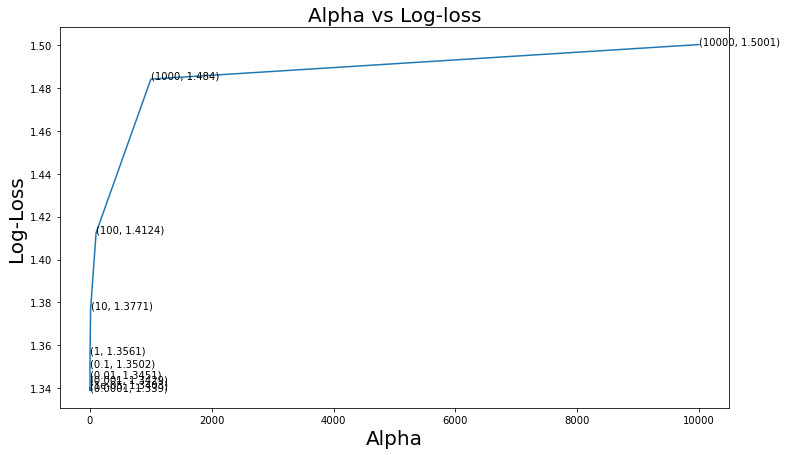

In [73]:
alpha = [10**x for x in range(-5, 5)]

cv_log_loss = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(Train_X, Train_Y)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    #The CalibratedClassifierCV class is used to calibrate a classifier. CalibratedClassifierCV uses a cross-validation
    #approach to ensure unbiased data is always used to fit the calibrator. The data is split into k (train_set, test_set) 
    #couples (as determined by cv ).
    
    calib_clf.fit(Train_X, Train_Y)
    predicted_y = calib_clf.predict_proba(CV_X)
    cv_log_loss.append(log_loss(CV_Y, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

<h2>Testing with best hyper-parameter</h2>

In [74]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = MultinomialNB(alpha=best_alpha)
clf.fit(Train_X, Train_Y)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(Train_X, Train_Y)

predict_train = calib_clf.predict_proba(Train_X)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(CV_X)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(Test_X)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clf.classes_))

For values of best alpha =  0.0001 the train log loss =: 0.8994315727452437
For values of best alpha =  0.0001 the CV log loss =: 1.3390288124148533
For values of best alpha =  0.0001 the test log loss =: 1.2826554376098047


In [75]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 40.68%
Percentage of mis-classified for Test points = 39.61%


In [76]:
table = table.append(pd.DataFrame([["Naive Bayes", 0.9031, 1.3471, 1.2976, "42.75%", "39.46%", "GoodFit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

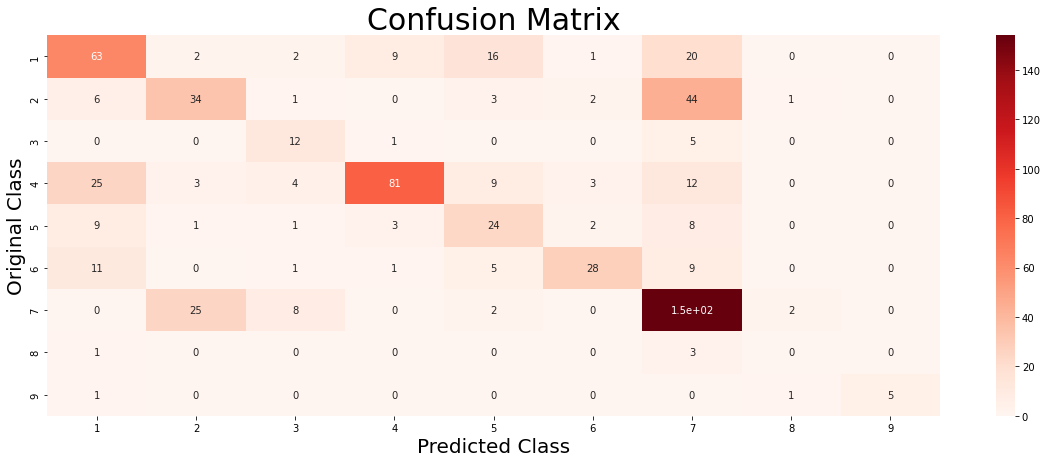

-----------------------------------------------------------------------------------------------------------------------------


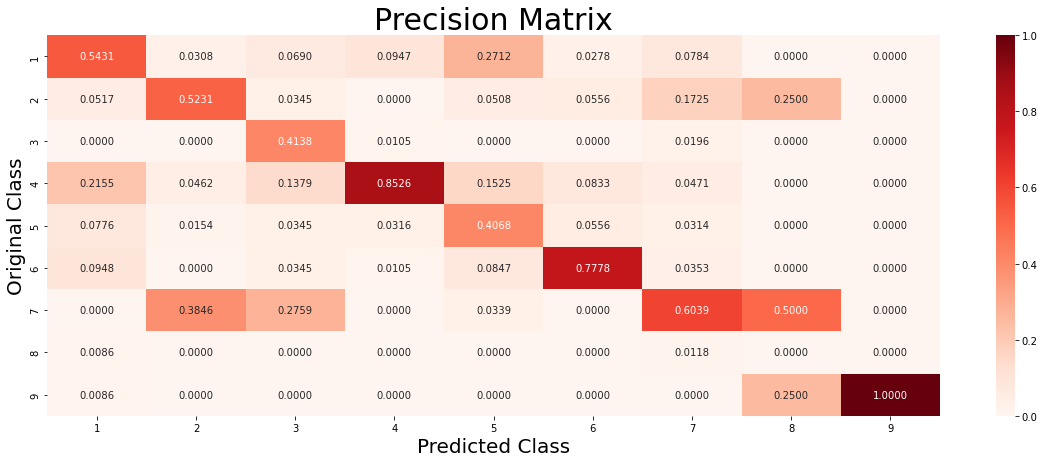

-----------------------------------------------------------------------------------------------------------------------------


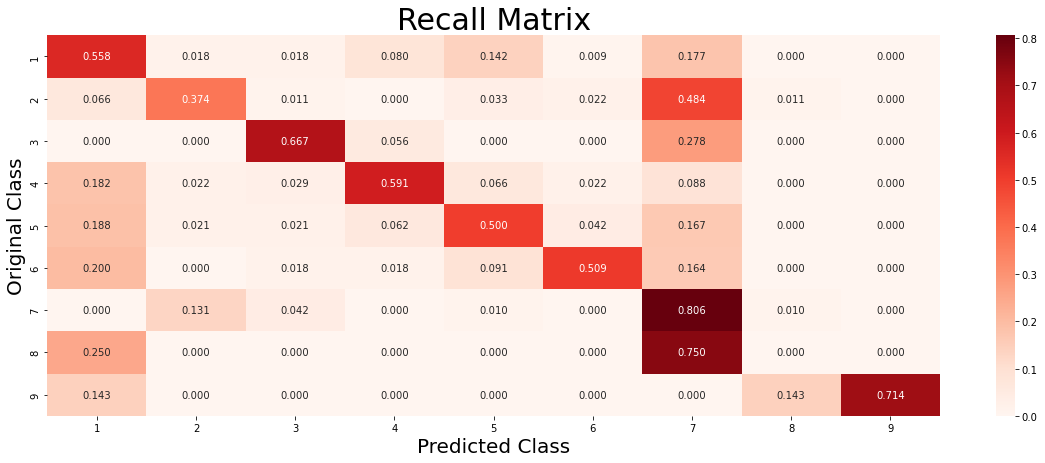

In [77]:
print_confusionMatrix(Test_Y, calib_clf.predict(Test_X))

<h2>Checking first 100 important features for correctly classified test point</h2>

In [78]:
testDataPoint = 5            #we are taking the fifth training example.
no_feature = 100             #?
predicted_cls = calib_clf.predict(Test_X[testDataPoint])   #predicted_y   #calib_clf is our model
TrueLabel = Test_Y[testDataPoint]                          #true_y
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 4)  #probability of success return garxa
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point = "+str(predicted_prob))
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*63)
getImportantFeatures(indices[0], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 4
Predicted Probabilities for test point = [[0.0819 0.0732 0.0118 0.6714 0.0351 0.0361 0.0809 0.005  0.0046]]
True class label for test point = 4
---------------------------------------------------------------
1st Text feature [shown] is present in query point
2nd Text feature [results] is present in query point
3rd Text feature [protein] is present in query point
4th Text feature [using] is present in query point
5th Text feature [activity] is present in query point
6th Text feature [described] is present in query point
7th Text feature [proteins] is present in query point
8th Text feature [determined] is present in query point
9th Text feature [type] is present in query point
10th Text feature [previously] is present in query point
11th Text feature [mutations] is present in query point
12th Text feature [experiments] is present in query point
13th Text feature [indicated] is present in query point
14th Text feature [important] is present in que

<h2>Checking first 100 important features for incorrectly classified test point</h2>

In [79]:
testDataPoint = 10
no_feature = 100
predicted_cls = calib_clf.predict(Test_X[testDataPoint])
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 4)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point ", end='')
print(predicted_prob[0])
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*63)
getImportantFeatures(indices[0], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 6
Predicted Probabilities for test point [0.076  0.0685 0.0109 0.093  0.0326 0.6342 0.0758 0.0046 0.0043]
True class label for test point = 6
---------------------------------------------------------------
3rd Text feature [predicted] is present in query point
5th Text feature [expected] is present in query point
6th Text feature [analysis] is present in query point
8th Text feature [used] is present in query point
12th Text feature [57] is present in query point
14th Text feature [basis] is present in query point
18th Text feature [sequence] is present in query point
43rd Text feature [odds] is present in query point
54th Text feature [model] is present in query point
56th Text feature [significant] is present in query point
58th Text feature [known] is present in query point
61st Text feature [deleterious] is present in query point
66th Text feature [family] is present in query point
69th Text feature [personal] is present in query point
70th Te